In [1]:
from NuPyCEE import omega as o
from JINAPyCEE import omega_plus as op
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import corner
import emcee
from multiprocess import Pool
#from schwimmbad import MPIPool

In [2]:
m_DM_0=1e12

In [3]:
# Run an omega model for DM evolution
o_DM = o.omega(m_DM_0=m_DM_0, DM_evolution=True, print_off=True)

# Convert the evolution of the dark matter mass into an input array
# The timestepping of this input array does not need the same as OMEGA+
# DM_array[ time ][ mass]
DM_array = [None] * (o_DM.nb_timesteps+1)
for i_t in range(o_DM.nb_timesteps+1):
    DM_array[i_t] = [o_DM.history.age[i_t], o_DM.m_DM_t[i_t]]

In [4]:
static_params = {'mgal':1.0, 
                 'm_DM_0':m_DM_0,
                 'DM_array':DM_array,
                 'DM_outflow_C17':True,
                 'C17_eta_z_dep':True,
                 'redshift_f':0.0,
                 'f_t_ff':10,
                 "imf_yields_range":[1,30],
                 'imf_type':'kroupa', # default
                 'imf_bdys':[0.1,100.], # default
                 'sfe_m_dep':False,
                 'Grackle_on':True,
                 'special_timesteps':150,
                 'print_off':True
                }

In [5]:
def model(theta):
    # t_star will override f_dyn
    # with DM_evolution, mass_loading references late-time
    fit_params = {"t_star":theta[0],
                  'sfe':theta[1]*1e-10,
                  #'sfe_m_index':theta[2],
                  'mass_loading':theta[2],
                  'exp_ml':theta[3]
                 }

    model = op.omega_plus(**static_params, **fit_params)
    
    return model

In [6]:
# data order: M_star/1e10, SFR, M_gas/1e9, rate_inflow, SNCC/100yr, SNIa/100yr
obsv_mean = np.array([3.5, 1.825, 8.1, #1.1, 
                      2e-2, 0.4e-2])
obsv_stdv = np.array([0.5, 1.175, 4.5, #0.5,
                      1e-2, 0.2e-2])

In [7]:
def get_observables(op_model):
    inflow_rate_exp = op_model.inner.m_inflow_t/op_model.inner.history.timesteps
    final_inflow = inflow_rate_exp[-1]

    # Get the total mass of gas [Msun]
    m_gas_exp = np.zeros(op_model.inner.nb_timesteps+1)
    for i_t in range(op_model.inner.nb_timesteps+1):
        m_gas_exp[i_t] = sum(op_model.inner.ymgal[i_t])
    final_mass_gas = m_gas_exp[-1]

    # Get the total mass lost by stars [Msun]
    m_star_lost = 0.0
    for i_t in range(op_model.inner.nb_timesteps):
        m_star_lost += np.sum(op_model.inner.mdot[i_t])
    # Stellar mass [Msun] .. corrected for stellar mass loss
    final_mass_star = np.sum(op_model.inner.history.m_locked)-m_star_lost

    # Get the CC and Ia SNe rates [yr^-1]
    cc_sne_rate = op_model.inner.history.sn2_numbers[1:]/op_model.inner.history.timesteps
    Ia_sne_rate = op_model.inner.history.sn1a_numbers[1:]/op_model.inner.history.timesteps
    final_cc_rate = cc_sne_rate[-1]
    final_Ia_rate = Ia_sne_rate[-1]

    final_sfr = op_model.inner.history.sfr_abs[-2]
    
    return np.array([final_mass_star/1e10, final_sfr, 
                     final_mass_gas/1e9, #final_inflow,
                     final_cc_rate, final_Ia_rate])

In [8]:
def log_prior(theta):
    if not np.logical_and(0.01 < theta, theta < 100.0).all():
        return -np.inf
    else:
        return 0

In [9]:
def log_likelihood(theta):
    model_inst = model(theta)
    model_data = get_observables(model_inst)
    
    ll = -0.5 * np.sum(np.log(2*np.pi*obsv_stdv)**2 + 
                       (obsv_mean-model_data)**2/obsv_stdv**2)
    
    return ll

In [10]:
def log_posterior(theta):
    return log_prior(theta) + log_likelihood(theta)

In [11]:
ndim = 4
nwalkers = 10  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

theta_inits = np.random.uniform(0.0, 10.0, (nwalkers, ndim))

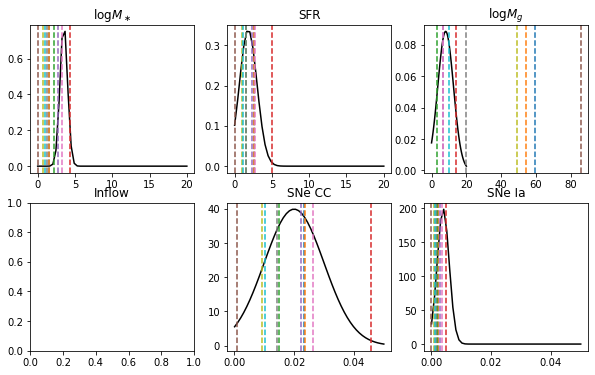

In [12]:
x1 = np.linspace(0, 20)
x2 = np.linspace(1e-4, 5e-2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))

ax[0,0].plot(x1, norm.pdf(x1, obsv_mean[0], obsv_stdv[0]), 'k')
ax[0,1].plot(x1, norm.pdf(x1, obsv_mean[1], obsv_stdv[1]), 'k')
ax[0,2].plot(x1, norm.pdf(x1, obsv_mean[2], obsv_stdv[2]), 'k')
#ax[1,0].plot(x1, norm.pdf(x1, obsv_mean[3], obsv_stdv[3]), 'k')
ax[1,1].plot(x2, norm.pdf(x2, obsv_mean[3], obsv_stdv[3]), 'k')
ax[1,2].plot(x2, norm.pdf(x2, obsv_mean[4], obsv_stdv[4]), 'k')

ax[0,0].set_title(r'$\log M_\ast$')
ax[0,1].set_title('SFR')
ax[0,2].set_title(r'$\log M_g$')
ax[1,0].set_title('Inflow')
ax[1,1].set_title("SNe CC")
ax[1,2].set_title("SNe Ia")


for i in range(nwalkers):

    test_model = model(theta_inits[i])
    results = get_observables(test_model)

    ax[0,0].axvline(results[0], c=f'C{i}', ls='--')
    ax[0,1].axvline(results[1], c=f'C{i}', ls='--')
    ax[0,2].axvline(results[2], c=f'C{i}', ls='--')
    #ax[1,0].axvline(results[3], c=f'C{i}', ls='--')
    ax[1,1].axvline(results[3], c=f'C{i}', ls='--')
    ax[1,2].axvline(results[4], c=f'C{i}', ls='--')

In [13]:
with Pool() as pool:
# with MPIPool() as pool:
#     if not pool.is_master():
#         pool.wait()
#         sys.exit(0)
        
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
    sampler.run_mcmc(theta_inits, nsteps, progress=True)

  0%|          | 3/5000 [00:50<22:42:28, 16.36s/it]Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
  0%|          | 3/5000 [01:17<35:55:18, 25.88s/it]Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:


emcee: Exception while calling your likelihood function:
  params: [ 8.98548103  3.47509535  9.12547562 -3.96532908]
  args: 

Traceback (most recent call last):
Traceback (most recent call last):


[]

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/claire/minicond

  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt


  kwargs:

  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()


{}

  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()



  exception:

  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()


Traceback (most recent call last):
KeyboardInterrupt
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/claire/miniconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/home/claire/miniconda3/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "<ipython-input-10-2a413fe7b9f3>", line 2, in log_posterior
  

KeyboardInterrupt: 